In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch import nn
import torch
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.express as px
import numpy as np
import holoviews as hv
from holoviews import opts
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader 
import plotly.express as px
import plotly.graph_objects as go

hv.extension('bokeh')

 #                           AQUIFER

Aquifer is an underground layer of water-bearing permeable rock, rock fractures or unconsolidated materials (gravel, sand, or silt). It can be extracted using a water well.



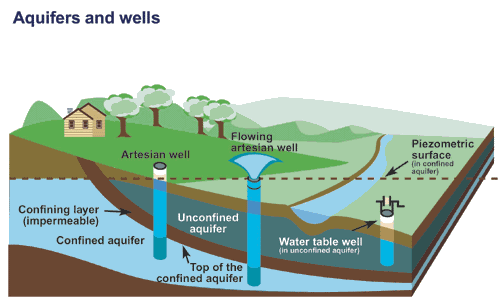

It has four different area Auser, Doganella, Luco, and Petrignano. Let's see the discription of their columns:

**Date:** Regular date (Primary key)
Rainfall_X: It indicates the quantity of rain falling, expressed in millimeters (mm), in the area X.

**Depth_to_Groundwater_Y:** It indicates the groundwater level, expressed in ground level (meters from the ground floor), detected by the piezometer Y.

**Temperature_Z:** It indicates the temperature, expressed in °C, detected by the thermometric station Z.

**Volume_H:** It indicates the volume of water, expressed in cubic meters (mc), taken from the drinking water treatment plant H.

**Hydrometry_K:** It indicates the groundwater level, expressed in meters (m), detected by the hydrometric station K.

From above, we know that for this water body we need a model which can predict Depth_to_Groundwater of water per seconds.

##        **Reading Data**

In [ ]:
data = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv')
data1 = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Auser.csv')
data2 = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Luco.csv')
data3 = pd.read_csv('/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv')

In [ ]:
all_col = [data,data1,data2,data3]
for idx, cols in enumerate(all_col):
    new_cols = []
    for col in cols.columns:
        if 'Rainfall' in col:
            new_name = col.replace('Rainfall', 'R')
        elif 'Depth_to_Groundwater' in col:
            new_name = col.replace('Depth_to_Groundwater', 'DG')
        elif 'Temperature' in col:
            new_name = col.replace('Temperature', 'T')
        elif 'Volume' in col:
            new_name = col.replace('Volume', 'V')
        elif 'Hydrometry' in col:
            new_name = col.replace('Hydrometry', 'H')
        else:
            new_name = col
        new_cols.append(new_name)
    cols.columns = new_cols

In [ ]:
# Convert Date object type column to datetime type
data['Date'] = pd.to_datetime(data.Date)
data1['Date'] = pd.to_datetime(data1.Date)
data2['Date'] = pd.to_datetime(data2.Date)
data3['Date'] = pd.to_datetime(data3.Date)

In [ ]:
plt.figure(figsize=(18, 8))
plt.title('Doganella correlation heatmap',fontsize=50)
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=0.2, cmap='PuBuGn')
plt.show()

plt.figure(figsize=(18, 8))
plt.title('Auser correlation heatmap',fontsize=50)
sns.heatmap(data1.corr(), annot=True, fmt='.2f', linewidths=0.2, cmap='PuBuGn')
plt.show()



In [ ]:
plt.figure(figsize=(18, 8))
plt.title('Luco correlation heatmap',fontsize=50)
sns.heatmap(data2.corr(), annot=True, fmt='.2f', linewidths=0.2, cmap='PuBuGn')
plt.show()

plt.figure(figsize=(18, 8))
plt.title('Petrignano correlation heatmap',fontsize=50)
sns.heatmap(data3.corr(), annot=True, fmt='.2f', linewidths=0.2, cmap='PuBuGn')
plt.show()

# **LAKE**

In [ ]:
Lake_Bilancino = pd.read_csv("../input/acea-water-prediction/Lake_Bilancino.csv")

In [ ]:
Lake_Bilancino.describe()

In [ ]:
def box_plot(df, id_begin = 1, id_last = 5):
    fig = go.Figure()
    for column in df.columns[id_begin:id_last]:

        fig.add_trace(go.Box(y=df[column], name = column))
        fig.update_traces(boxpoints='outliers', 
                          jitter= 0)

    return fig.show()


box_plot(Lake_Bilancino, id_last = 5)

In [ ]:
fig = px.line(Lake_Bilancino, x=Lake_Bilancino['Date'], y=Lake_Bilancino['Temperature_Le_Croci'], 
              title='Temperature_Le_Croci')
fig.show()

In [ ]:
box_plot(Lake_Bilancino, id_begin = 6, id_last = 7)

In [ ]:
fig = px.line(Lake_Bilancino, x=Lake_Bilancino['Date'], y=Lake_Bilancino['Lake_Level'], 
              title='Lake_Level')
fig.show()

In [ ]:
box_plot(Lake_Bilancino, id_begin = 7, id_last = 8)

In [ ]:
fig = px.line(Lake_Bilancino, x=Lake_Bilancino['Date'], y=Lake_Bilancino['Flow_Rate'], 
              title='Flow_Rate')
fig.show()

In [ ]:
box_plot(Lake_Bilancino, id_begin = 8, id_last = 9)

In [ ]:
def granger_causality_tests(df, maxlag = 12):

    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    variables = df.columns
    granger_pvalue_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))))

    for i, variable_c in enumerate(variables):
        for j, variable_r in enumerate(variables):
            min_p_value = np.min([grangercausalitytests(df[[variable_c, variable_r]].dropna(), 
                     maxlag = maxlag, verbose = False)[i][0]['ssr_chi2test'][1] for i in range(1, maxlag+1)])
            granger_pvalue_matrix.loc[i, j] = min_p_value

    granger_pvalue_matrix.columns = [var + '_x' for var in variables]
    granger_pvalue_matrix.index = [var + '_y' for var in variables]
    return granger_pvalue_matrix

def draw_granger_pvalue_matrix(granger_pvalue_matrix):
    fig = go.Figure(data=go.Heatmap(z = granger_pvalue_matrix, 
                                    x = granger_pvalue_matrix.columns, 
                                    y = granger_pvalue_matrix.index, 
                                    colorscale = [[0, 'green'], [0.05, 'green'],
                                                  [0.05, 'red'], [1, 'red']
                                                  ]))
    fig.update_layout(title="Minimum of p_values for a maxlag of 12 of a Granger test")
    return fig.show()

In [ ]:
granger_pvalue_matrix = granger_causality_tests(Lake_Bilancino.iloc[578:, 1:].dropna())
draw_granger_pvalue_matrix(granger_pvalue_matrix)

In [ ]:
def draw_correlation_matrix(df, method = 'pearson'):
    pct_change_list = []
    for column in df.columns[1:]:
        pct_change_list.append(df[column].pct_change().replace([np.inf, -np.inf], np.nan).dropna())
    pct_change_array = np.zeros((len(df.columns[1:]), len(df.columns[1:])))
    for i, pct_change_i in enumerate(pct_change_list):
        for j, pct_change_j in enumerate(pct_change_list):
            pct_change_array[i, j] = pct_change_i.corr(pct_change_j, method)
    fig = px.imshow(pct_change_array,
                    x=df.columns[1:],
                    y=df.columns[1:]
                   )
    fig.update_xaxes(title = "Correlation matrix", side="top")
    return fig.show()
draw_correlation_matrix(Lake_Bilancino.iloc[:, 1:], method = "pearson")

In [ ]:
def scale_and_split(df):
    scaler = StandardScaler()
    transformer = scaler.fit_transform(df.iloc[:, 1:])
    df_scaled = pd.DataFrame(transformer, columns = df.columns[1:])
    train, val = train_test_split(df_scaled, test_size=0.33, shuffle = False)
    val, test = train_test_split(val, test_size=0.5, shuffle = False)
    return train, val, test, scaler

def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):
    X_train, y_train = train[:len(train)-seq_len][inputs], train[[output]]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
parameters = {'inputs':['Lake_Level', 'Flow_Rate'],
              'outputs':['Lake_Level', 'Flow_Rate'],
              'seq_len': 30,
              'batch_size_train':32,
              'batch_size_val':8,
              'batch_size_test':8,
              'lr':0.0005,
              'epochs':20
             }

train, val, test, scaler = scale_and_split(Lake_Bilancino.iloc[578:]) 
X_train, y_train, X_val, y_val, X_test, y_test = prepare_inputs_outputs(train, val, test, 
                                                                        parameters['seq_len'], 
                                                                        parameters['inputs'], 
                                                                        parameters['outputs'][0])
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.index, y=X_train['Lake_Level'],
                    mode='lines',
                    name='train data'))
fig.add_trace(go.Scatter(x=X_val.index, y=X_val['Lake_Level'],
                    mode='lines',
                    name='validation data'))
fig.add_trace(go.Scatter(x=X_test.index, y=X_test['Lake_Level'],
                    mode='lines', 
                    name='test data'))
fig.update_layout(title = 'Lake level cutted into train, validation and test dataset (normalized)')

fig.show() 

In [ ]:
from torch.utils.data import Dataset
class TimeSeries(Dataset):
    def __init__(self, X, y, seq_len = 30):
        self.X = torch.tensor(np.array(X) ,dtype=torch.float32)
        self.y = torch.tensor(np.array(y) ,dtype=torch.float32)
        #self.column_input = column_input
        #self.column_output = column_output
        self.seq_len = seq_len
        
    def __getitem__(self,idx):
        return self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len]

    def __len__(self):
        return len(self.X) - (self.seq_len-1)
    
    
def get_dataloader(X, y, batch_size):
    return DataLoader(TimeSeries(X, y), shuffle=False, batch_size=32, drop_last = True)


if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"

In [ ]:
class MTS_RNN(nn.Module):
    def __init__(self, input_size=8, hidden_layer_size=20, output_size=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        predictions = self.linear(output[:, -1])
        return predictions

In [ ]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs):


    train_val_history = {'train': [],
                        'val': []}
    for i in range(epochs):
        for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            y_pred = model(inputs)

            single_loss = torch.sqrt(loss_function(y_pred, labels))

            single_loss.backward()

            optimizer.step()

        train_val_history['train'].append(single_loss.item())
        #print("Training data : " + f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        for j, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            y_pred = model(inputs)

            single_loss = torch.sqrt(loss_function(y_pred, labels))

        train_val_history['val'].append(single_loss.item())
        #print("Validation data : " + f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, train_val_history




def draw_training_loss(train_val_history, epochs):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(epochs), y=np.array(train_val_history['train']),
                        mode='lines',
                        name = 'train'))
    fig.add_trace(go.Scatter(x=np.arange(epochs), y=np.array(train_val_history['val']),
                        mode='lines',
                        name = 'validation'))
    fig.update_layout(title="Training and validation loss",
                      xaxis_title="Epochs",
                      yaxis_title="MSE loss",)

    return fig.show()


def predict_and_draw(df, test_loader, output, scaler, model, y_test, loss_function, draw = False):

    test_output = []
    test_output_grad = []
    for j, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs.requires_grad = True
        y_pred = model(inputs)
        single_loss = loss_function(y_pred, labels)

        test_output.append(y_pred)
        
        single_loss.backward()
 
        test_output_grad.append(torch.mean(inputs.grad, axis = 0))
        
    gradient_input_mean = np.sort(np.absolute(torch.mean(torch.cat(test_output_grad), axis = 0)
                                      .detach().numpy()))
    
    indice_outputs = [i - 1 for i, x in enumerate(df.columns.isin(output)) if x]
    mean = [mean for i, mean in enumerate(scaler.mean_) if i in indice_outputs]
    var = [var for i, var in enumerate(scaler.var_) if i in indice_outputs]
    
    predictions = pd.DataFrame(torch.cat(test_output).detach().numpy(), columns = output)
    
    predictions = predictions * var + mean
    y = y_test[parameters['seq_len']:] * var + mean
    
    def draw(predictions, y, output):
        fig = make_subplots(rows=2, cols=1, 
                           subplot_titles=("Prediction on test dataset for " + output ,
                                           "Feature importance by derivarive importance for " + output))
        fig.add_trace(go.Scatter(x=np.arange(len(predictions)), y=np.array(predictions[output]),
                            mode='lines',
                            name = 'predictions'), row = 1, col = 1)
        fig.add_trace(go.Scatter(x=np.arange(len(predictions)), y=np.array(y[output]),
                            mode='lines',
                            name = 'ground truth'), row = 1, col = 1)
        
        fig.add_trace(go.Bar(x=df.columns[1:], y = gradient_input_mean, 
                            name = 'gradient of lstm w.r.t. features'), row = 2, col = 1)

        return fig.show()

    if draw:
        draw(predictions, y, output[0])
 
    return y, predictions

def train_predict_and_draw(parameters, df, output):
    train, val, test, scaler = scale_and_split(df) 
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_inputs_outputs(train, val, test, 
                                                                            parameters['seq_len'], 
                                                                            parameters['inputs'], 
                                                                            output)

    train_loader = get_dataloader(X_train, y_train, parameters['batch_size_train'])
    val_loader = get_dataloader(X_val, y_val, parameters['batch_size_val'])
    test_loader = get_dataloader(X_test, y_test, parameters['batch_size_test'])
    model = MTS_RNN(input_size=len(parameters['inputs']), hidden_layer_size=20, output_size=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
    loss_function = nn.MSELoss()

    model_LSTM, train_val_history = train_model(model, 
                                                train_loader, 
                                                val_loader,
                                                loss_function, 
                                                optimizer, 
                                                parameters['epochs'])

    draw_training_loss(train_val_history, parameters['epochs'])

    y, predictions = predict_and_draw(df, test_loader, [output], scaler, model, y_test, loss_function, 
                                      draw = True)
    return y, predictions



### **Output for lake level**

In [ ]:
parameters = {'inputs':Lake_Bilancino.columns[1:],
              'outputs':['Lake_Level', 'Flow_Rate'],
            'seq_len': 30,
              'batch_size_train':32,
              'batch_size_val':8,
              'batch_size_test':8,
              'lr':0.002,
              'epochs':20
             }

y, predictions = train_predict_and_draw(parameters, Lake_Bilancino.iloc[578:], parameters['outputs'][0])

In [ ]:
ab=mean_squared_error(y[:len(predictions)], predictions)
print('The RMSE of the model is :',ab)
aaa=mean_squared_error(y[:len(predictions)], predictions, squared = False)
print('The MSE of the model is :',aaa)

### **Output for Flow_rate**

In [ ]:
parameters = {'inputs':Lake_Bilancino.columns[1:],
              'outputs':['Lake_Level', 'Flow_Rate'],
            'seq_len': 30,
              'batch_size_train':32,
              'batch_size_val':8,
              'batch_size_test':8,
              'lr':0.0001,
              'epochs':40
             }

y, predictions = train_predict_and_draw(parameters, Lake_Bilancino.iloc[578:], parameters['outputs'][1])

In [ ]:
ab1=mean_squared_error(y[:len(predictions)], predictions)
print('The RMSE of the model is :',ab)
aaa1=mean_squared_error(y[:len(predictions)], predictions, squared = False)
print('The MSE of the model is :',aaa1)